# Classificação de genes codificantes de beta-lactamases utilizando rede neural recorrente

In [1]:
import numpy as np
np.random.seed(1)
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
tf.random.set_seed(1)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
import random as rn
rn.seed(1)
os.environ['PYTHONHASHSEED'] = '1'
from Bio import SeqIO
from collections import Counter
import csv
import pandas as pd
import sklearn
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# Banco de dados

In [2]:
classA = 'Class A betalactamases'
classB = 'Class B betalactamases'
classC = 'Class C betalactamases'
classD = 'Class D betalactamases'

In [3]:
def split_train_test_valid(seq_code,seq_class,x1,x2):
    idx0 = round(x1*len(seq_code))
    idx1 = round((x1+x2)*len(seq_code))
    (seq_code, seq_class) = sklearn.utils.shuffle(seq_code, seq_class, random_state=0)
    train_x = seq_code[0:idx0]
    train_y = seq_class[0:idx0]
    test_x = seq_code[idx0:idx1]
    test_y = seq_class[idx0:idx1]
    valid_x = seq_code[idx1:]
    valid_y = seq_class[idx1:]
    return(train_x,train_y,test_x,test_y,valid_x,valid_y)


In [4]:
def letter2code(sequences):
    dict_ = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8, 'I': 9, 'J': 10, 
             'K': 11, 'L': 12, 'M': 13, 'N': 14, 'O': 15, 'P': 16, 'Q': 17, 'R': 18, 'S': 19, 
             'T': 20, 'U': 21, 'V': 22, 'W': 23, 'Y': 24, 'Z': 25, 'X': 26, '*': 0, '-': 0}
    seq_code = []
    seq_len = []
    for i in sequences:
        j = []
        for letter in i:
            j.append(dict_.get(letter))
        seq_code.append(j)
        seq_len.append(len(j))
    seq_code = np.array(seq_code, dtype=object)
    seq_len = np.array(seq_len)
    return seq_code, seq_len

In [5]:
def get_key_from_value(d, val):
    keys = [k for k, v in d.items() if v == val]
    if keys:
        return keys[0]
    return None

In [6]:
def code2letter(sequences):
    dict_ = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8, 'I': 9, 'J': 10, 
             'K': 11, 'L': 12, 'M': 13, 'N': 14, 'O': 15, 'P': 16, 'Q': 17, 'R': 18, 'S': 19, 
             'T': 20, 'U': 21, 'V': 22, 'W': 23, 'Y': 24, 'Z': 25, 'X': 26, '*': 0, '-': 0}
    seq_code = []
    seq_len = []
    for i in sequences:
        j = ''
        for number in i:
            j+=str(get_key_from_value(dict_,number))
        seq_code.append(j)
        seq_len.append(len(j))
    #seq_code = np.array(seq_code, dtype=object)
    #seq_len = np.array(seq_len)
    return seq_code, seq_len

### MEGARes 2.0

In [7]:
df = pd.read_csv('Dados/megares/megares_drugs_annotations_v2.00.csv')
df

,header,type,class,mechanism,group
0,MEG_372|Multi-compound|Drug_and_biocide_resist...,Drugs,Multi-drug resistance,Multi-drug MATE efflux pumps,ABEM
1,MEG_373|Multi-compound|Drug_and_biocide_resist...,Drugs,Multi-drug resistance,Multi-drug MATE efflux pumps,ABEM
2,MEG_374|Multi-compound|Drug_and_biocide_resist...,Drugs,Multi-drug resistance,Multi-drug SMR efflux pumps,ABES
3,MEG_375|Multi-compound|Drug_and_biocide_resist...,Drugs,Multi-drug resistance,Multi-drug SMR efflux pumps,ABES
4,MEG_376|Multi-compound|Drug_and_biocide_resist...,Drugs,Multi-drug resistance,Multi-drug SMR efflux pumps,ABES
...,...,...,...,...,...
7121,MEG_7807|Drugs|betalactams|Class_A_betalactama...,Drugs,betalactams,Class A betalactamases,WHH
7122,MEG_7840|Drugs|Lipopeptides|Defensin-resistant...,Drugs,Lipopeptides,Defensin-resistant mutant,YKKCL
7123,MEG_7843|Drugs|Lipopeptides|Daptomycin-resista...,Drugs,Lipopeptides,Daptomycin-resistant mutant,YYBT
7124,MEG_7844|Drugs|Glycopeptides|Bleomycin_resista...,Drugs,Glycopeptides,Bleomycin resistance protein,ZBMA


In [8]:
df0 = df[df['mechanism']==classA]
df1 = df[df['mechanism']==classB]
df2 = df[df['mechanism']==classC]
df3 = df[df['mechanism']==classD]


In [9]:
header = [list(df0['header']),
          list(df1['header']),
          list(df2['header']),
          list(df3['header'])]


In [10]:
file = "Dados/megares/megares_drugs_database_v2.00.fasta"
output_file = "Dados/megares/megares_drugs_database_v2.00_amino_acids.fasta"

input_handle = open(file, "r")
output_handle = open(output_file, "w")

for i in SeqIO.parse(input_handle, "fasta"):
    output_handle.write(">%s\n%s\n" % (i.id,i.seq.translate()))


In [11]:
file = "Dados/megares/megares_drugs_database_v2.00_amino_acids.fasta"
fa = SeqIO.parse(file, "fasta")

seq = [[],[],[],[]]
seq_id = [[],[],[],[]]

for i in fa:
    if i.id in header[0]:
        seq[0].append(str(i.seq))
        seq_id[0].append(str(i.id))

    if i.id in header[1]:
        seq[1].append(str(i.seq))
        seq_id[1].append(str(i.id))
    
    if i.id in header[2]:
        seq[2].append(str(i.seq))
        seq_id[2].append(str(i.id))

    if i.id in header[3]:
        seq[3].append(str(i.seq))
        seq_id[3].append(str(i.id))

seq_class = [np.zeros(len(seq[0])),
             1*np.ones(len(seq[1])),
             2*np.ones(len(seq[2])),
             3*np.ones(len(seq[3]))]


In [12]:
print("0",classA,len(seq[0]))
print("1",classB,len(seq[1]))
print("2",classC,len(seq[2]))
print("3",classD,len(seq[3]))

0 Class A betalactamases 1579
1 Class B betalactamases 409
2 Class C betalactamases 950
3 Class D betalactamases 900


In [13]:
seq_code = [[],[],[],[]]
seq_len = [[],[],[],[]]
for i in range(len(seq)):
    seq_code[i],seq_len[i] = letter2code(seq[i])
    
max_len = max(np.max(seq_len[0]),np.max(seq_len[1]),np.max(seq_len[2]),np.max(seq_len[3]))
max_len

907

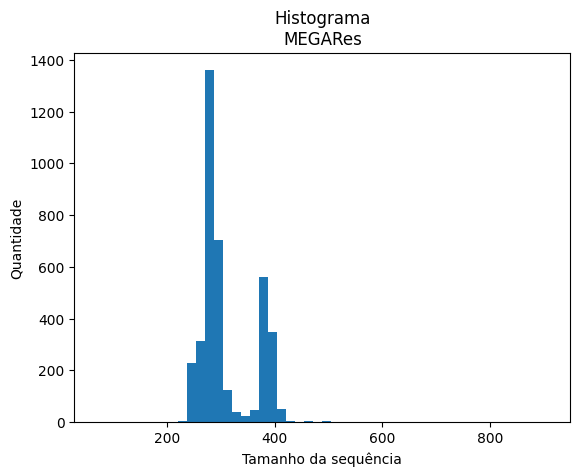

In [14]:
plt.figure()
hist = plt.hist(np.concatenate((seq_len[0],seq_len[1],seq_len[2],seq_len[3])),bins=50)
plt.xlabel('Tamanho da sequência')
plt.ylabel('Quantidade')
plt.title('Histograma\nMEGARes')
plt.savefig('Figuras/histograma_megares.png')

In [15]:
train_x = [[],[],[],[]]
train_y = [[],[],[],[]]
test_x = [[],[],[],[]]
test_y = [[],[],[],[]]
valid_x = [[],[],[],[]]
valid_y = [[],[],[],[]]

for i in range(len(seq_code)):
    train_x[i],train_y[i],test_x[i],test_y[i],valid_x[i],valid_y[i] = split_train_test_valid(seq_code[i],
                                                                                             seq_class[i],
                                                                                             0.70,0.15)


In [16]:
print("Training set")
print("0",classA,len(train_x[0]))
print("1",classB,len(train_x[1]))
print("2",classC,len(train_x[2]))
print("3",classD,len(train_x[3]))
print("Validation set")
print("0",classA,len(valid_x[0]))
print("1",classB,len(valid_x[1]))
print("2",classC,len(valid_x[2]))
print("3",classD,len(valid_x[3]))
print("Test set")
print("0",classA,len(test_x[0]))
print("1",classB,len(test_x[1]))
print("2",classC,len(test_x[2]))
print("3",classD,len(test_x[3]))

Training set
0 Class A betalactamases 1105
1 Class B betalactamases 286
2 Class C betalactamases 665
3 Class D betalactamases 630
Validation set
0 Class A betalactamases 237
1 Class B betalactamases 61
2 Class C betalactamases 142
3 Class D betalactamases 135
Test set
0 Class A betalactamases 237
1 Class B betalactamases 62
2 Class C betalactamases 143
3 Class D betalactamases 135


In [17]:
train_set = np.concatenate((train_x[0],train_x[1],train_x[2],train_x[3]))
train_target = np.concatenate((train_y[0],train_y[1],train_y[2],train_y[3]))
(train_set, train_target) = sklearn.utils.shuffle(train_set, train_target, random_state=0)

test_set = np.concatenate((test_x[0],test_x[1],test_x[2],test_x[3]))
test_target = np.concatenate((test_y[0],test_y[1],test_y[2],test_y[3]))

valid_set = np.concatenate((valid_x[0],valid_x[1],valid_x[2],valid_x[3]))
valid_target = np.concatenate((valid_y[0],valid_y[1],valid_y[2],valid_y[3]))

train_set_padded = tf.keras.preprocessing.sequence.pad_sequences(train_set, padding="post", maxlen=max_len)
test_set_padded = tf.keras.preprocessing.sequence.pad_sequences(test_set, padding="post", maxlen=max_len)
valid_set_padded = tf.keras.preprocessing.sequence.pad_sequences(valid_set, padding="post", maxlen=max_len)



In [18]:
np.savez("MEGARes_dataset_betalactam.npz", 
         train_x=train_set_padded, 
         train_y=train_target, 
         test_x=test_set_padded, 
         test_y=test_target, 
         validation_x=valid_set_padded, 
         validation_y=valid_target, 
         header=np.array(header, dtype=object))


# Treino

In [19]:
dataset=np.load('MEGARes_dataset_betalactam.npz', allow_pickle=True)

In [20]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(27, output_dim=8, mask_zero=True, embeddings_initializer="uniform"))
model.add(tf.keras.layers.LSTM(32))
model.add(tf.keras.layers.Dense(4))
model.add(tf.keras.layers.Softmax())
model.summary()
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

model.save('Modelos/model_LSTM.h5')

batch_size=32
checkpoint_path = "Modelos/cp_betalactam-{epoch:02d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 verbose=1,save_weights_only=True,save_freq='epoch')
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, 
                                              start_from_epoch=0)

epchs = 100
history = model.fit(dataset.f.train_x, tf.one_hot(dataset.f.train_y,4), epochs=epchs, verbose=1, shuffle=1, 
                    validation_data=(dataset.f.validation_x,tf.one_hot(dataset.f.validation_y,4)),
                    batch_size=batch_size, callbacks=[cp_callback,early_stop])

np.save('Modelos/history_betalactam.npy',history.history)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 8)           216       
                                                                 
 lstm (LSTM)                 (None, 32)                5248      
                                                                 
 dense (Dense)               (None, 4)                 132       
                                                                 
 softmax (Softmax)           (None, 4)                 0         
                                                                 
Total params: 5596 (21.86 KB)
Trainable params: 5596 (21.86 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
84/84 [==============================] - ETA: 0s - loss: 0.8622 - accuracy: 0.6493
Epoch 1: saving model to Modelos/cp_betalactam-01.ckpt
84/8

In [21]:
history = np.load('Modelos/history_betalactam.npy', allow_pickle=True)
print('Max validation accuracy:',np.max(history.item()['val_accuracy']))
arg_val = np.argmax(history.item()['val_accuracy'])
print('Epoch',arg_val+1)
print('Validation loss:',history.item()['val_loss'][arg_val])


Max validation accuracy: 0.9686956405639648
Epoch 19
Validation loss: 0.19063104689121246


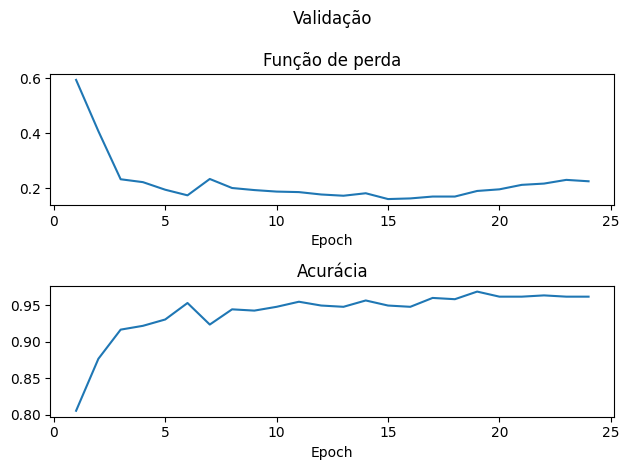

In [22]:
n = len(history.item()['val_accuracy'])

plt.figure()
plt.subplot(211)
plt.title('Validação\n\nFunção de perda')
plt.plot(list(range(1,n+1)), history.item()['val_loss'][0:n], label='validation loss')
plt.xlabel('Epoch')

plt.subplot(212)
plt.title('Acurácia')
plt.plot(list(range(1,n+1)), history.item()['val_accuracy'][0:n], label='validation accuracy')
plt.xlabel('Epoch')
plt.tight_layout()
plt.savefig('Figuras/valid_loss_acc.png')
plt.show()


# Teste

In [23]:
dataset=np.load('MEGARes_dataset_betalactam.npz', allow_pickle=True)
history = np.load('Modelos/history_betalactam.npy', allow_pickle=True)
arg_val = np.argmax(history.item()['val_accuracy'])

In [24]:
model = tf.keras.models.load_model('Modelos/model_LSTM.h5')
# Load weights from Epoch X
if arg_val+1 >= 10:
    model.load_weights('Modelos/cp_betalactam-%s.ckpt' % (str(arg_val+1)))
else:
    model.load_weights('Modelos/cp_betalactam-0%s.ckpt' % (str(arg_val+1)))

19/19 [==============================] - 1s 35ms/step
Matriz de confusão


<Figure size 640x480 with 0 Axes>

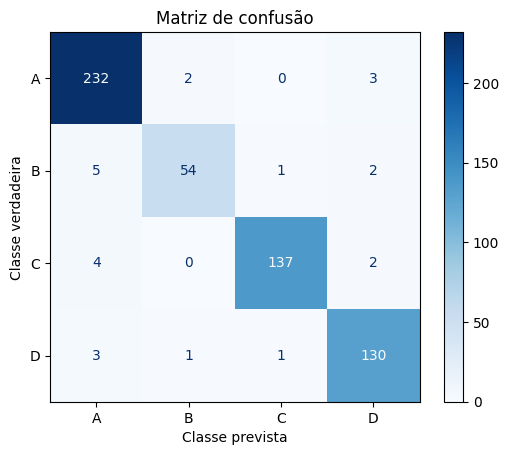

In [25]:
predictions = model.predict(dataset.f.test_x, verbose=1)

print('Matriz de confusão')
labels = [classA,classB,classC,classD]
labels = ['A','B','C','D']
cm = confusion_matrix(dataset.f.test_y, np.argmax(predictions, axis=1))

%matplotlib inline
plt.figure()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')
plt.title('Matriz de confusão')
plt.xlabel('Classe prevista')
plt.ylabel('Classe verdadeira')
plt.savefig('Figuras/cm.png')
plt.show()

In [26]:
model.evaluate(dataset.f.test_x, tf.one_hot(dataset.f.test_y,4), verbose=1)

19/19 [==============================] - 1s 36ms/step - loss: 0.1705 - accuracy: 0.9584


[0.1704988330602646, 0.9584055542945862]

In [27]:
from sklearn.metrics import classification_report
print('MEGARes')
print(classification_report(dataset.f.test_y, np.argmax(predictions, axis=1), 
                            target_names=['Class A', 'Class B', 'Class C', 'Class D']))


MEGARes
              precision    recall  f1-score   support

     Class A       0.95      0.98      0.96       237
     Class B       0.95      0.87      0.91        62
     Class C       0.99      0.96      0.97       143
     Class D       0.95      0.96      0.96       135

    accuracy                           0.96       577
   macro avg       0.96      0.94      0.95       577
weighted avg       0.96      0.96      0.96       577



# Baía de Guanabara

In [28]:
classA = 'Class A betalactamases'
classB = 'Class B betalactamases'
classC = 'Class C betalactamases'
classD = 'Class D betalactamases'

In [29]:
dataset=np.load('MEGARes_dataset_betalactam.npz', allow_pickle=True)
header = dataset.f.header
max_len = dataset.f.train_x.shape[1]
max_len

907

In [30]:
df = pd.read_csv('Dados/Diamond/BG_MEGARes_matches.tsv', sep='\t', header=None)
df.columns = ['query_accession','target_accession','sequence_identity','length',
              'mismatches','gap_openings','query_start','query_end','target_start',
              'target_end','e_value','bit_score']
df

,query_accession,target_accession,sequence_identity,length,mismatches,gap_openings,query_start,query_end,target_start,target_end,e_value,bit_score
0,NODE_1_length_40712_cov_12.792877_17,MEG_7414|Drugs|Glycopeptides|VanB-type_resista...,33.3,231,135,4,64,280,73,298,2.110000e-29,112.0
1,NODE_1_length_40712_cov_12.792877_17,MEG_7413|Drugs|Glycopeptides|VanB-type_resista...,32.1,252,150,5,45,280,52,298,7.850000e-29,110.0
2,NODE_1_length_40712_cov_12.792877_17,MEG_7415|Drugs|Glycopeptides|VanB-type_resista...,32.9,231,136,4,64,280,73,298,7.850000e-29,110.0
3,NODE_1_length_40712_cov_12.792877_17,MEG_7416|Drugs|Glycopeptides|VanB-type_resista...,32.0,231,138,4,64,280,73,298,1.060000e-26,104.0
4,NODE_1_length_40712_cov_12.792877_17,MEG_7335|Drugs|Glycopeptides|VanA-type_resista...,31.7,252,151,6,45,280,52,298,2.820000e-26,103.0
...,...,...,...,...,...,...,...,...,...,...,...,...
196052,NODE_1164114_length_66_cov_9.000000_1,MEG_3984|Drugs|MLS|Macrolide-resistant_23S_rRN...,77.3,22,5,0,1,22,914,935,1.130000e-06,38.9
196053,NODE_1164116_length_66_cov_9.000000_1,MEG_3988|Drugs|MLS|Macrolide-resistant_23S_rRN...,86.4,22,3,0,1,22,805,826,4.940000e-08,42.7
196054,NODE_1164116_length_66_cov_9.000000_1,MEG_3982|Drugs|MLS|Macrolide-resistant_23S_rRN...,86.4,22,3,0,1,22,874,895,1.260000e-07,41.6
196055,NODE_1165304_length_66_cov_3.000000_1,MEG_3988|Drugs|MLS|Macrolide-resistant_23S_rRN...,86.4,22,3,0,1,22,805,826,7.540000e-09,45.1


In [31]:
df_f = df.query('sequence_identity >= 30 and length >= 100')
id_ref = []
for i in list(df_f['target_accession']):
    x1 = i.find("|")
    id_ref.append(i[0:x1])
    
df_f.insert(loc=2, column='id_ref', value= id_ref)  


In [32]:
ref_0 = header[0]
ref_1 = header[1]
ref_2 = header[2]
ref_3 = header[3]

df0 = df_f[df_f.target_accession.isin(ref_0)]
df1 = df_f[df_f.target_accession.isin(ref_1)]
df2 = df_f[df_f.target_accession.isin(ref_2)]
df3 = df_f[df_f.target_accession.isin(ref_3)]

In [33]:
query_accession = [list(df0['query_accession']),
                   list(df1['query_accession']),
                   list(df2['query_accession']),
                   list(df3['query_accession'])]

query_start = [list(df0.query_start),
               list(df1.query_start),
               list(df2.query_start),
               list(df3.query_start)]
query_end = [list(df0.query_end),
             list(df1.query_end),
             list(df2.query_end),
             list(df3.query_end)]


In [34]:
BG_id = []
BG_seq = []

file = "Dados/BG_Prodigal/BG.proteins.faa"
fa = SeqIO.parse(file, "fasta")

for i in fa:
    BG_id.append(i.id)
    BG_seq.append(str(i.seq))

In [35]:
seq = [[],[],[],[]]
seq_id = [[],[],[],[]]
k=0
for i in range(len(query_accession)):
    for j in range(len(query_accession[i])):
        if (query_end[i][j]-query_start[i][j]) >= 100 and (query_end[i][j]-query_start[i][j]) < max_len:
            if query_accession[i][j] in BG_id:
                idx = BG_id.index(query_accession[i][j])
                seq[i].append(str(BG_seq[idx][query_start[i][j]:query_end[i][j]]))
                seq_id[i].append(str(BG_id[idx]))
                k+=1

seq_class = [np.zeros(len(seq[0])),
             1*np.ones(len(seq[1])),
             2*np.ones(len(seq[2])),
             3*np.ones(len(seq[3]))]      

In [36]:
print("0",classA,len(seq[0]))
print("1",classB,len(seq[1]))
print("2",classC,len(seq[2]))
print("3",classD,len(seq[3]))

0 Class A betalactamases 85
1 Class B betalactamases 236
2 Class C betalactamases 602
3 Class D betalactamases 41


In [37]:
seq_code = [[],[],[],[]]
seq_len = [[],[],[],[]]
for i in range(len(seq)):
    seq_code[i],seq_len[i] = letter2code(seq[i])


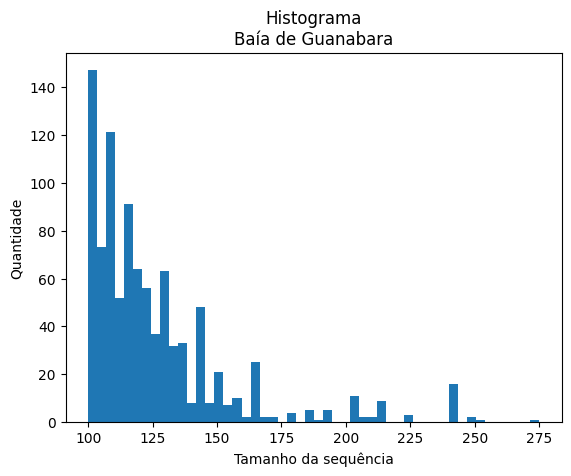

In [38]:
plt.figure()
hist = plt.hist(np.concatenate((seq_len[0],seq_len[1],seq_len[2],seq_len[3])),bins=50)
plt.xlabel('Tamanho da sequência')
plt.ylabel('Quantidade')
plt.title('Histograma\nBaía de Guanabara')
plt.savefig(('Figuras/histograma_bg.png'))

In [39]:
train_x = [[],[],[],[]]
train_y = [[],[],[],[]]
test_x = [[],[],[],[]]
test_y = [[],[],[],[]]
valid_x = [[],[],[],[]]
valid_y = [[],[],[],[]]
 
for i in range(len(seq_code)):
    train_x[i],train_y[i],test_x[i],test_y[i],valid_x[i],valid_y[i] = split_train_test_valid(seq_code[i],
                                                                                             seq_class[i],
                                                                                             0.70,0.15)

In [40]:
print("Training set")
print("0",classA,len(train_x[0]))
print("1",classB,len(train_x[1]))
print("2",classC,len(train_x[2]))
print("3",classD,len(train_x[3]))
print("Validation set")
print("0",classA,len(valid_x[0]))
print("1",classB,len(valid_x[1]))
print("2",classC,len(valid_x[2]))
print("3",classD,len(valid_x[3]))
print("Test set")
print("0",classA,len(test_x[0]))
print("1",classB,len(test_x[1]))
print("2",classC,len(test_x[2]))
print("3",classD,len(test_x[3]))

Training set
0 Class A betalactamases 59
1 Class B betalactamases 165
2 Class C betalactamases 421
3 Class D betalactamases 29
Validation set
0 Class A betalactamases 13
1 Class B betalactamases 35
2 Class C betalactamases 90
3 Class D betalactamases 6
Test set
0 Class A betalactamases 13
1 Class B betalactamases 36
2 Class C betalactamases 91
3 Class D betalactamases 6


In [41]:
train_set = np.concatenate((train_x[0],train_x[1],train_x[2],train_x[3]))
train_target = np.concatenate((train_y[0],train_y[1],train_y[2],train_y[3]))
(train_set, train_target) = sklearn.utils.shuffle(train_set, train_target, random_state=0)

test_set = np.concatenate((test_x[0],test_x[1],test_x[2],test_x[3]))
test_target = np.concatenate((test_y[0],test_y[1],test_y[2],test_y[3]))

valid_set = np.concatenate((valid_x[0],valid_x[1],valid_x[2],valid_x[3]))
valid_target = np.concatenate((valid_y[0],valid_y[1],valid_y[2],valid_y[3]))

train_set_padded = tf.keras.preprocessing.sequence.pad_sequences(train_set, padding="post", maxlen=max_len)
test_set_padded = tf.keras.preprocessing.sequence.pad_sequences(test_set, padding="post", maxlen=max_len)
valid_set_padded = tf.keras.preprocessing.sequence.pad_sequences(valid_set, padding="post", maxlen=max_len)


In [42]:
np.savez("BG_dataset_betalactam.npz", 
         train_x=train_set_padded,
         train_y=train_target, 
         test_x=test_set_padded, 
         test_y=test_target,
         validation_x=valid_set_padded, 
         validation_y=valid_target)

# Transferência de aprendizado

In [43]:
BG_dataset = np.load('BG_dataset_betalactam.npz', allow_pickle=True)

In [44]:
BG_dataset.f.train_x.shape

(674, 907)

In [45]:
model = tf.keras.models.load_model('Modelos/model_LSTM.h5')
history = np.load('Modelos/history_betalactam.npy', allow_pickle=True)
print('Min validation loss:',np.max(history.item()['val_loss']))
arg_val = np.argmin(history.item()['val_loss'])
print('Epoch',arg_val+1)
print('Validation accuracy:',history.item()['val_accuracy'][arg_val])

if arg_val+1 >= 10:
    model.load_weights('Modelos/cp_betalactam-%s.ckpt' % (str(arg_val+1)))
else:
    model.load_weights('Modelos/cp_betalactam-0%s.ckpt' % (str(arg_val+1)))

Min validation loss: 0.5939855575561523
Epoch 15
Validation accuracy: 0.9495652318000793


In [46]:
batch_size=32
checkpoint_path = "Modelos/cp1_betalactam-{epoch:02d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 verbose=1,save_weights_only=True,save_freq='epoch')
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, 
                                              start_from_epoch=0)

epchs = 100
history = model.fit(BG_dataset.f.train_x, tf.one_hot(BG_dataset.f.train_y,4), epochs=epchs, verbose=1, shuffle=1, 
                    validation_data=(BG_dataset.f.validation_x,tf.one_hot(BG_dataset.f.validation_y,4)),
                    batch_size=batch_size, callbacks=[cp_callback,early_stop])

np.save('Modelos/history1_betalactam.npy',history.history)

Epoch 1/100
22/22 [==============================] - ETA: 0s - loss: 1.2835 - accuracy: 0.5653
Epoch 1: saving model to Modelos/cp1_betalactam-01.ckpt
22/22 [==============================] - 7s 235ms/step - loss: 1.2835 - accuracy: 0.5653 - val_loss: 0.7782 - val_accuracy: 0.6944
Epoch 2/100
22/22 [==============================] - ETA: 0s - loss: 0.5742 - accuracy: 0.7834
Epoch 2: saving model to Modelos/cp1_betalactam-02.ckpt
22/22 [==============================] - 4s 202ms/step - loss: 0.5742 - accuracy: 0.7834 - val_loss: 0.5632 - val_accuracy: 0.8472
Epoch 3/100
22/22 [==============================] - ETA: 0s - loss: 0.4309 - accuracy: 0.8605
Epoch 3: saving model to Modelos/cp1_betalactam-03.ckpt
22/22 [==============================] - 4s 199ms/step - loss: 0.4309 - accuracy: 0.8605 - val_loss: 0.5283 - val_accuracy: 0.8403
Epoch 4/100
22/22 [==============================] - ETA: 0s - loss: 0.3228 - accuracy: 0.8961
Epoch 4: saving model to Modelos/cp1_betalactam-04.ckpt
22/

In [47]:
history = np.load('Modelos/history1_betalactam.npy', allow_pickle=True)
print('Max validation accuracy:',np.max(history.item()['val_accuracy']))
arg_val = np.argmax(history.item()['val_accuracy'])
print('Epoch',arg_val+1)
print('Validation loss:',history.item()['val_loss'][arg_val])

Max validation accuracy: 0.9166666865348816
Epoch 15
Validation loss: 0.31807181239128113


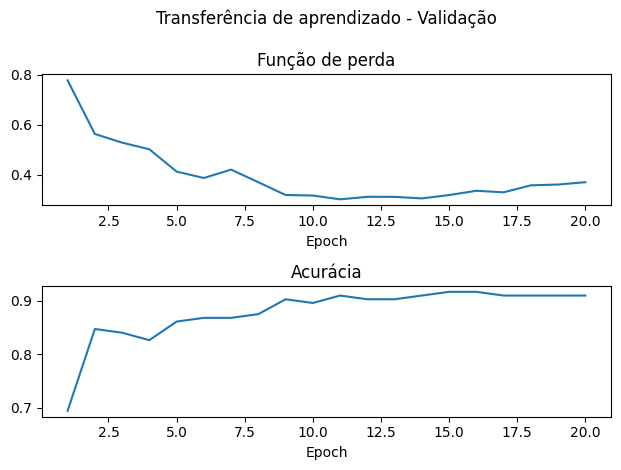

In [48]:
n = len(history.item()['val_accuracy'])

plt.figure()
plt.subplot(211)
plt.title('Transferência de aprendizado - Validação\n\nFunção de perda')
plt.plot(list(range(1,n+1)), history.item()['val_loss'][0:n], label='validation loss')
plt.xlabel('Epoch')

plt.subplot(212)
plt.title('Acurácia')
plt.plot(list(range(1,n+1)), history.item()['val_accuracy'][0:n], label='validation accuracy')
plt.xlabel('Epoch')
plt.tight_layout()
plt.savefig('Figuras/valid_loss_acc1.png')
plt.show()

# Teste - Baía de Guanabara

In [49]:
model = tf.keras.models.load_model('Modelos/model_LSTM.h5')
history = np.load('Modelos/history_betalactam.npy', allow_pickle=True)
arg_val = np.argmax(history.item()['val_accuracy'])

if arg_val+1 >= 10:
    model.load_weights('Modelos/cp1_betalactam-%s.ckpt' % (str(arg_val+1)))
else:
    model.load_weights('Modelos/cp1_betalactam-0%s.ckpt' % (str(arg_val+1)))


5/5 [==============================] - 1s 35ms/step
Matriz de confusão


<Figure size 640x480 with 0 Axes>

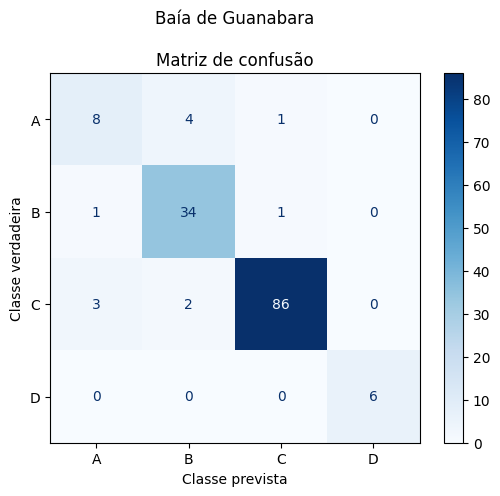

In [50]:
predictions = model.predict(BG_dataset.f.test_x, verbose=1)

print('Matriz de confusão')
labels = [classA,classB,classC,classD]
labels = ['A','B','C','D']
cm = confusion_matrix(BG_dataset.f.test_y, np.argmax(predictions, axis=1))

%matplotlib  inline
plt.figure()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues')
plt.title('Baía de Guanabara\n\nMatriz de confusão')
plt.xlabel('Classe prevista')
plt.ylabel('Classe verdadeira')
plt.savefig('Figuras/cm_BG.png')
plt.show()

In [51]:
model.evaluate(BG_dataset.f.test_x, tf.one_hot(BG_dataset.f.test_y,4), verbose=1)

5/5 [==============================] - 1s 38ms/step - loss: 0.2679 - accuracy: 0.9178


[0.2679135501384735, 0.9178082346916199]

In [52]:
from sklearn.metrics import classification_report
print('MEGARes and BG')
print(classification_report(BG_dataset.f.test_y, np.argmax(predictions, axis=1), 
                            target_names=['Class A', 'Class B', 'Class C', 'Class D']))

MEGARes and BG
              precision    recall  f1-score   support

     Class A       0.67      0.62      0.64        13
     Class B       0.85      0.94      0.89        36
     Class C       0.98      0.95      0.96        91
     Class D       1.00      1.00      1.00         6

    accuracy                           0.92       146
   macro avg       0.87      0.88      0.87       146
weighted avg       0.92      0.92      0.92       146

